In [1]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    """Fully Connected Neural Network (FCN) for general use.
    
    Parameters:
    - N_INPUT (int): Number of input features.
    - N_OUTPUT (int): Number of output features.
    - N_HIDDEN (int): Number of neurons per hidden layer.
    - N_LAYERS (int): Number of hidden layers.
    
    Returns:
    - Forward pass output tensor.
    """
    
    def __init__(self, N_INPUT: int, N_OUTPUT: int, N_HIDDEN: int, N_LAYERS: int):
        super().__init__()
        
        activation = nn.Tanh  # Can be changed to any other activation function
        
        # Input layer
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        
        # Hidden layers (fixed syntax issue)
        if N_LAYERS > 1:
            hidden_layers = []
            for _ in range(N_LAYERS - 1):
                hidden_layers.append(nn.Linear(N_HIDDEN, N_HIDDEN))
                hidden_layers.append(activation())
            self.fch = nn.Sequential(*hidden_layers)
        else:
            self.fch = nn.Identity()  # No hidden layers, just pass through
        
        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)  # Input layer
        x = self.fch(x)  # Hidden layers
        x = self.fce(x)  # Output layer
        return x

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([1500, 1]) torch.Size([1500, 1])
torch.Size([20, 1]) torch.Size([20, 1])


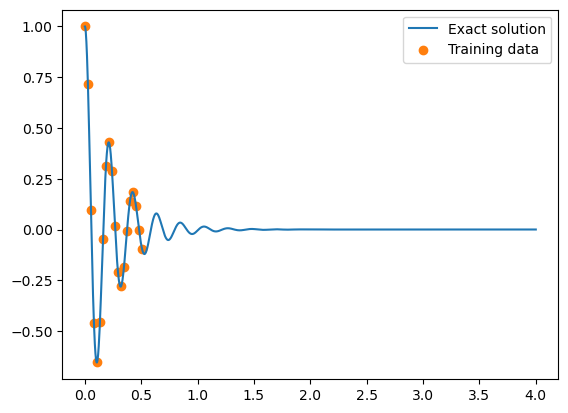

In [7]:
d, w0 = 4, 30

# get the analytical solution over the full domain
x = torch.linspace(0,4,1500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:10]
y_data = y[0:200:10]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

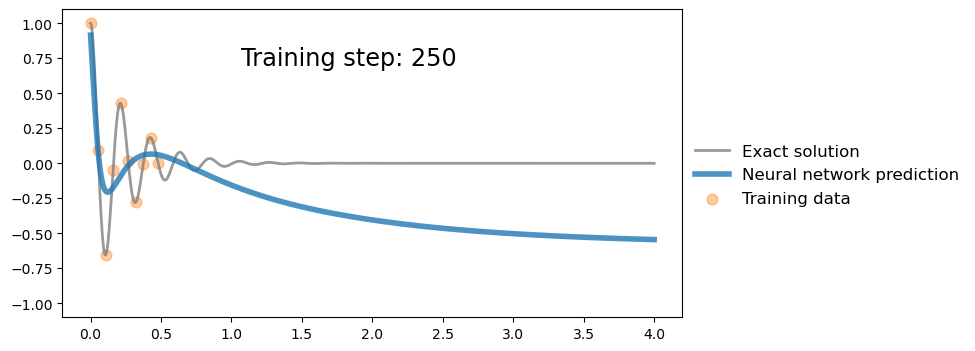

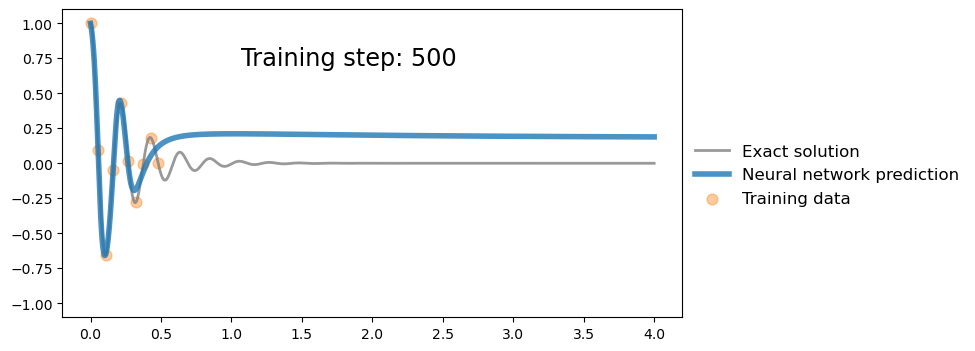

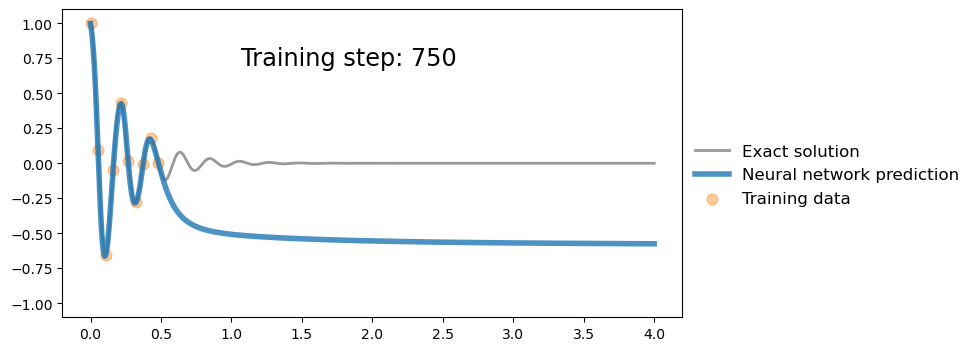

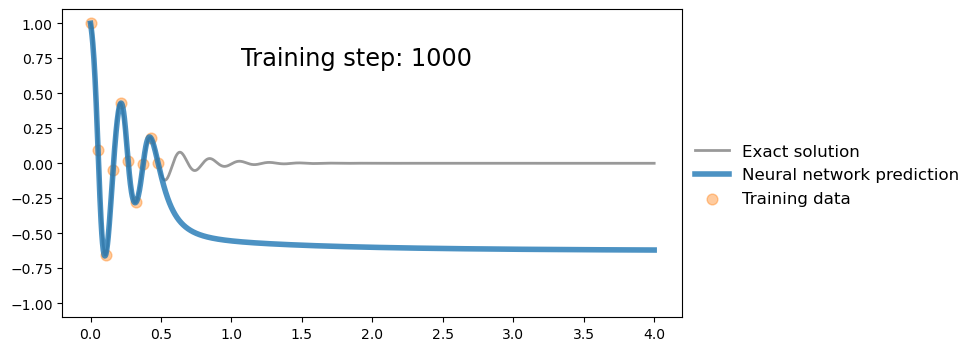

In [5]:
import torch
import matplotlib.pyplot as plt

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    # plt.axis("off")
    
# Train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh - y_data) ** 2)  # Mean Squared Error
    loss.backward()
    optimizer.step()

    # Plot the result as training progresses
    if (i + 1) % 250 == 0:
        yh = model(x).detach()
        plot_result(x, y, x_data, y_data, yh)  # Pass step for dynamic title

/home/gosh/anaconda3/envs/torch25/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1728945379270/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 1000, Loss: 0.172837, Learning Rate: 0.001
Iteration 2000, Loss: 0.172594, Learning Rate: 0.001
Iteration 3000, Loss: 0.172510, Learning Rate: 0.001
Iteration 4000, Loss: 0.172439, Learning Rate: 0.001
Iteration 5000, Loss: 0.172131, Learning Rate: 0.001
Iteration 6000, Loss: 0.171460, Learning Rate: 0.001
Iteration 7000, Loss: 0.169664, Learning Rate: 0.001
Iteration 8000, Loss: 0.158184, Learning Rate: 0.001
Iteration 9000, Loss: 0.108903, Learning Rate: 0.001
Iteration 10000, Loss: 0.080513, Learning Rate: 0.001


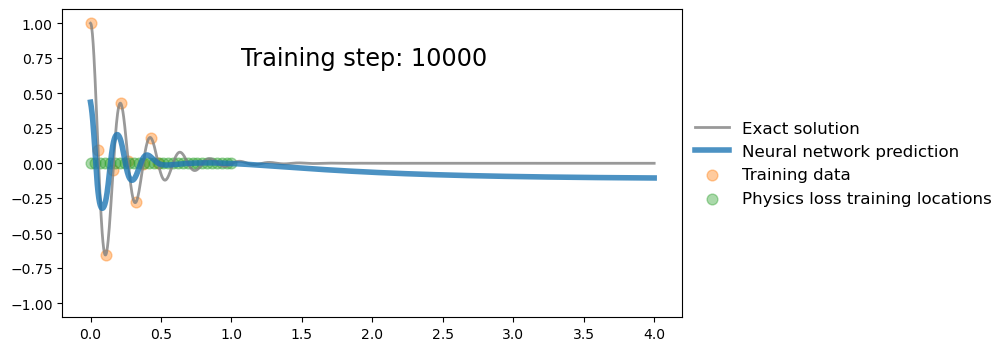

Iteration 11000, Loss: 0.066603, Learning Rate: 0.001
Iteration 12000, Loss: 0.052858, Learning Rate: 0.001
Iteration 13000, Loss: 0.010832, Learning Rate: 0.001
Iteration 14000, Loss: 0.005073, Learning Rate: 0.001
Iteration 15000, Loss: 0.003423, Learning Rate: 0.001
Iteration 16000, Loss: 0.002627, Learning Rate: 0.001
Iteration 17000, Loss: 0.002307, Learning Rate: 0.001
Iteration 18000, Loss: 0.002360, Learning Rate: 0.001
Iteration 19000, Loss: 0.002004, Learning Rate: 0.001
Iteration 20000, Loss: 0.001869, Learning Rate: 0.001


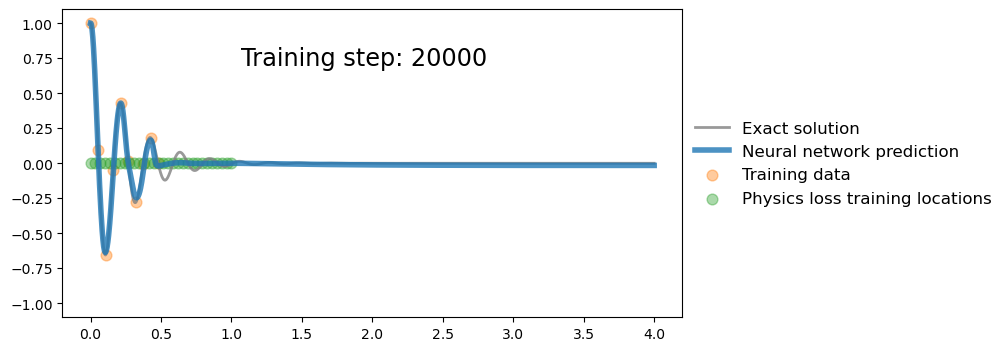

Iteration 21000, Loss: 0.001750, Learning Rate: 0.0005
Iteration 22000, Loss: 0.001632, Learning Rate: 0.0005
Iteration 23000, Loss: 0.001480, Learning Rate: 0.0005
Iteration 24000, Loss: 0.001290, Learning Rate: 0.0005
Iteration 25000, Loss: 0.001128, Learning Rate: 0.0005
Iteration 26000, Loss: 0.000981, Learning Rate: 0.0005
Iteration 27000, Loss: 0.000828, Learning Rate: 0.0005
Iteration 28000, Loss: 0.000709, Learning Rate: 0.0005
Iteration 29000, Loss: 0.000656, Learning Rate: 0.0005
Iteration 30000, Loss: 0.000667, Learning Rate: 0.0005


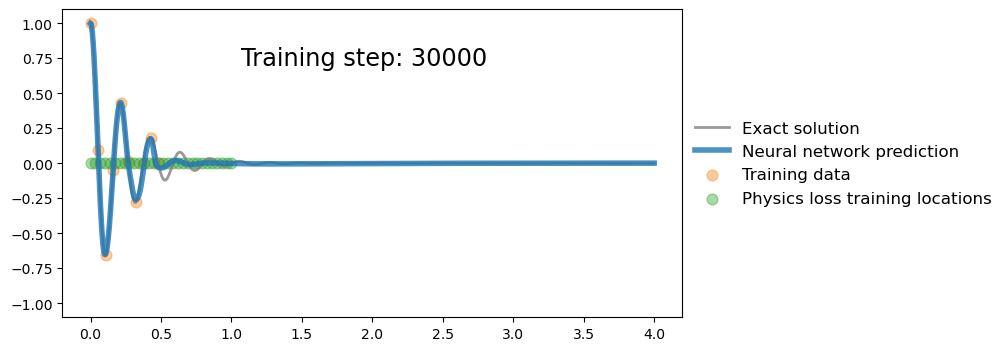

Iteration 31000, Loss: 0.000625, Learning Rate: 0.0005
Iteration 32000, Loss: 0.000637, Learning Rate: 0.0005
Iteration 33000, Loss: 0.000604, Learning Rate: 0.0005
Iteration 34000, Loss: 0.000844, Learning Rate: 0.0005
Iteration 35000, Loss: 0.000588, Learning Rate: 0.0005
Iteration 36000, Loss: 0.000616, Learning Rate: 0.0005
Iteration 37000, Loss: 0.000571, Learning Rate: 0.0005
Iteration 38000, Loss: 0.001035, Learning Rate: 0.0005
Iteration 39000, Loss: 0.000593, Learning Rate: 0.0005
Iteration 40000, Loss: 0.000526, Learning Rate: 0.0005


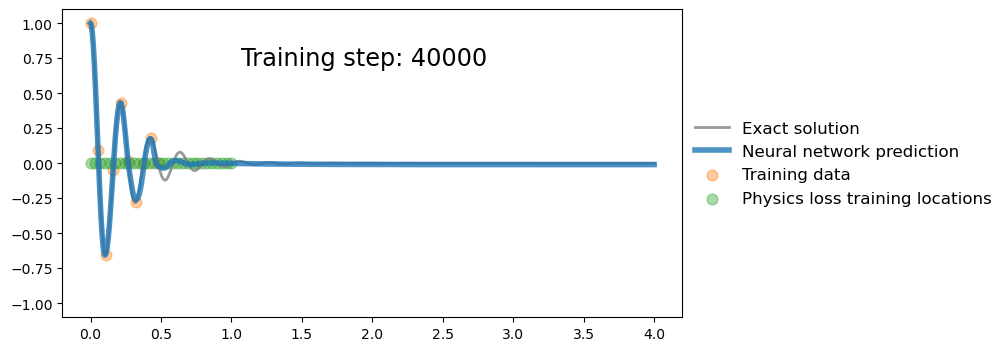

Iteration 41000, Loss: 0.000688, Learning Rate: 0.0005
Iteration 42000, Loss: 0.000470, Learning Rate: 0.0005
Iteration 43000, Loss: 0.000458, Learning Rate: 0.0005
Iteration 44000, Loss: 0.000444, Learning Rate: 0.0005
Iteration 45000, Loss: 0.000437, Learning Rate: 0.0005
Iteration 46000, Loss: 0.000422, Learning Rate: 0.0005
Iteration 47000, Loss: 0.000437, Learning Rate: 0.0005
Iteration 48000, Loss: 0.000412, Learning Rate: 0.0005
Iteration 49000, Loss: 0.000407, Learning Rate: 0.0005
Iteration 50000, Loss: 0.000399, Learning Rate: 0.0005


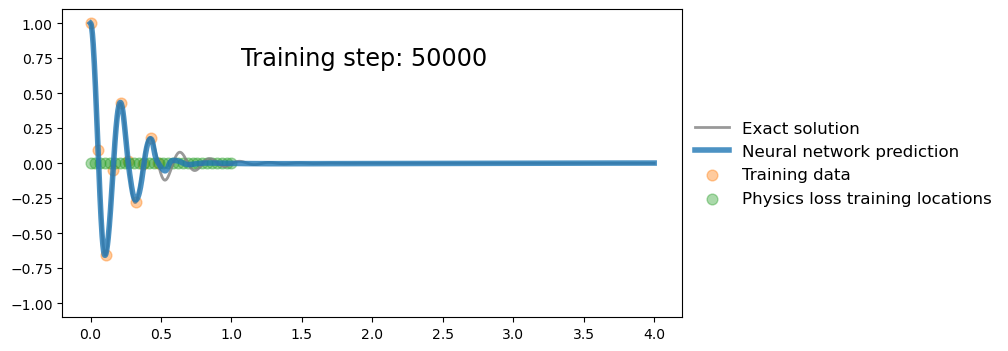

Iteration 51000, Loss: 0.000394, Learning Rate: 0.0005
Iteration 52000, Loss: 0.000389, Learning Rate: 0.0005
Iteration 53000, Loss: 0.000384, Learning Rate: 0.0005
Iteration 54000, Loss: 0.000415, Learning Rate: 0.0005
Iteration 55000, Loss: 0.000422, Learning Rate: 0.0005
Iteration 56000, Loss: 0.000364, Learning Rate: 0.0005
Iteration 57000, Loss: 0.000354, Learning Rate: 0.0005
Iteration 58000, Loss: 0.000342, Learning Rate: 0.0005
Iteration 59000, Loss: 0.000326, Learning Rate: 0.0005
Iteration 60000, Loss: 0.000306, Learning Rate: 0.0005


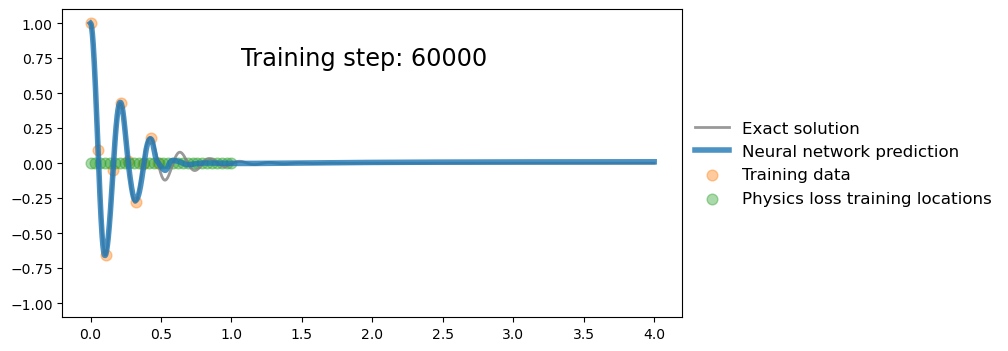

Iteration 61000, Loss: 0.000321, Learning Rate: 0.0005
Iteration 62000, Loss: 0.000303, Learning Rate: 0.0005
Iteration 63000, Loss: 0.000361, Learning Rate: 0.0005
Iteration 64000, Loss: 0.000204, Learning Rate: 0.0005
Iteration 65000, Loss: 0.000181, Learning Rate: 0.0005
Iteration 66000, Loss: 0.000158, Learning Rate: 0.0005
Iteration 67000, Loss: 0.000137, Learning Rate: 0.0005
Iteration 68000, Loss: 0.000134, Learning Rate: 0.0005
Iteration 69000, Loss: 0.000103, Learning Rate: 0.0005
Iteration 70000, Loss: 0.000089, Learning Rate: 0.0005


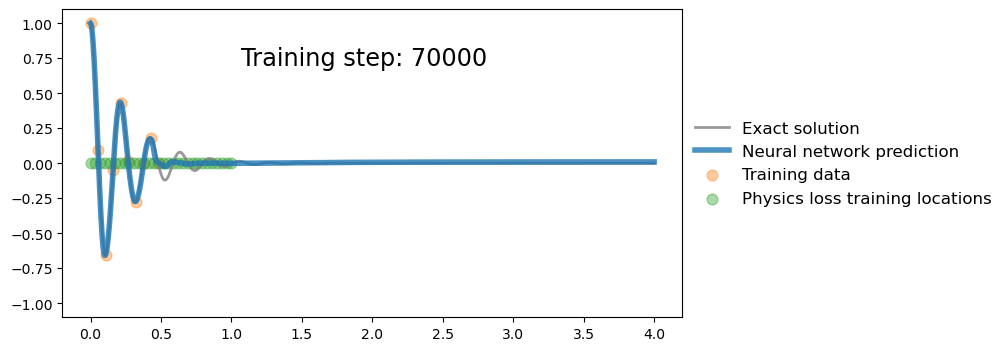

Iteration 71000, Loss: 0.000083, Learning Rate: 0.00025
Iteration 72000, Loss: 0.000077, Learning Rate: 0.00025
Iteration 73000, Loss: 0.000069, Learning Rate: 0.00025
Iteration 74000, Loss: 0.000062, Learning Rate: 0.00025
Iteration 75000, Loss: 0.000072, Learning Rate: 0.00025
Iteration 76000, Loss: 0.000056, Learning Rate: 0.00025
Iteration 77000, Loss: 0.000043, Learning Rate: 0.00025
Iteration 78000, Loss: 0.000056, Learning Rate: 0.00025
Iteration 79000, Loss: 0.000034, Learning Rate: 0.00025
Iteration 80000, Loss: 0.000034, Learning Rate: 0.00025


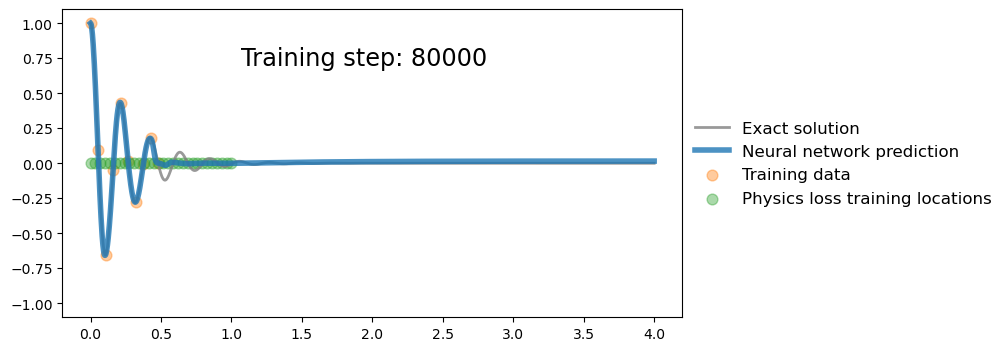

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize CUDA (Prevents cuBLAS issues)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.init()  # Explicitly initialize CUDA

# Sample locations over the problem domain
x_physics = torch.linspace(0, 1, 30).view(-1, 1).to(device).requires_grad_(True)

mu, k = 2 * d, w0**2

torch.manual_seed(123)
model = FCN(1, 1, 128, 2).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Adaptive Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500)

files = []
for i in range(80_000):
    optimizer.zero_grad()
    
    # Move data to GPU
    x_data, y_data = x_data.to(device), y_data.to(device)

    # Compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)  # Mean Squared Error
    
    # Compute the "physics loss"
    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp).to(device), create_graph=True)[0]  # Computes dy/dx
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx).to(device), create_graph=True)[0]  # Computes d^2y/dx^2
    physics = dx2 + mu * dx + k * yhp  # Residual of the 1D harmonic oscillator equation
    loss2 = (1e-4) * torch.mean(physics**2)
    
    # Backpropagate joint loss
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    # Adjust learning rate based on loss
    scheduler.step(loss.item())

    # Print learning rate when it changes
    if (i + 1) % 1000 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}, Learning Rate: {current_lr}")

    # Plot the result as training progresses
    if (i + 1) % 100 == 0:
        x, y = x.to(device), y.to(device)  # Move x and y to GPU
        yh = model(x).detach().cpu()
        xp = x_physics.detach().cpu()
        
        plot_result(x.cpu(), y.cpu(), x_data.cpu(), y_data.cpu(), yh, xp)

        if (i + 1) % 10_000 == 0:
            plt.show()
        else:
            plt.close("all")
